In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math
import random
import zipfile
from PIL import Image, ImageEnhance

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img, array_to_img

In [2]:
train_data = pd.read_csv('../../ubc/train.csv')
tma_data = train_data[train_data['is_tma'] == True]

In [3]:
extracted_tma_dir = '../TMA_images'
augmented_tma_dir = './augmented-tma-2'

# Update the original_tma_dir to point to the directory with extracted TMA images
original_tma_dir = os.path.join(extracted_tma_dir, 'train_images')

In [4]:
datagen = ImageDataGenerator(
    rotation_range=45,                   # Slight rotation
    brightness_range=[0.8, 1.2],         # Adjust brightness
    shear_range=0.1,                     # Slight shear
    zoom_range=[0.90, 1.05],             # Slight zoom
    channel_shift_range=0.3,             # Channel shifts for color variation
    horizontal_flip=True,                # Horizontal flip
    vertical_flip=True,                  # Vertical flip
    fill_mode='reflect'                  # Fill mode
)

In [5]:
def random_augment(image):
    # Randomly convert to array and back to handle both PIL images and arrays
    if isinstance(image, np.ndarray):
        image = array_to_img(image)
    else:
        image = image

    # Random brightness
    if random.choice([True, False]):
        enhancer = ImageEnhance.Brightness(image)
        image = enhancer.enhance(random.uniform(0.8, 1.2))

    # Random contrast (add more similar blocks for other enhancements)
    if random.choice([True, False]):
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(random.uniform(0.8, 1.2))

    # Convert back to array
    image = img_to_array(image)
    return image


In [6]:
def augment_and_save(image_path, num_augmented, save_dir, original_label, original_image_id):
    img = load_img(image_path)
    img_array = img_to_array(img)

    augmented_image_data = []
    for i in range(1, num_augmented + 1):
        # Apply random custom augmentations
        augmented_img = random_augment(img_array)
        
        # Apply ImageDataGenerator transformations
        for batch in datagen.flow(augmented_img.reshape((1,) + augmented_img.shape), batch_size=1):
            new_image_id = f"{original_image_id}_{i}"
            new_image_path = os.path.join(save_dir, f"{new_image_id}.png")
            save_img(new_image_path, batch[0])
            print(f"Saved image: {new_image_path}")  # Debugging print

            new_row = {
                'image_id': new_image_id,
                'label': original_label,
                'image_width': img.width,
                'image_height': img.height,
                'is_tma': True,
                'path': new_image_path
            }
            augmented_image_data.append(new_row)
            break  # Only one batch per augmentation

    return augmented_image_data


# Augment images for each row in the DataFrame
augmented_data = []
for _, row in tma_data.iterrows():
    image_path = os.path.join(original_tma_dir, f"{row['image_id']}.png")
    augmented_rows = augment_and_save(image_path, 13, augmented_tma_dir, row['label'], row['image_id'])
    augmented_data.extend(augmented_rows)

# Create DataFrame from augmented image data
augmented_image_df = pd.DataFrame(augmented_data)

# Combine original and augmented data
combined_tma = pd.concat([tma_data, augmented_image_df], ignore_index=True)
combined_tma['path'] = combined_tma['image_id'].apply(lambda x: f"{augmented_tma_dir}/{x}.png")

Saved image: ./augmented-tma-2/91_1.png
Saved image: ./augmented-tma-2/91_2.png
Saved image: ./augmented-tma-2/91_3.png
Saved image: ./augmented-tma-2/91_4.png
Saved image: ./augmented-tma-2/91_5.png
Saved image: ./augmented-tma-2/91_6.png
Saved image: ./augmented-tma-2/91_7.png
Saved image: ./augmented-tma-2/91_8.png
Saved image: ./augmented-tma-2/91_9.png
Saved image: ./augmented-tma-2/91_10.png
Saved image: ./augmented-tma-2/91_11.png
Saved image: ./augmented-tma-2/91_12.png
Saved image: ./augmented-tma-2/91_13.png
Saved image: ./augmented-tma-2/4134_1.png
Saved image: ./augmented-tma-2/4134_2.png
Saved image: ./augmented-tma-2/4134_3.png
Saved image: ./augmented-tma-2/4134_4.png
Saved image: ./augmented-tma-2/4134_5.png
Saved image: ./augmented-tma-2/4134_6.png
Saved image: ./augmented-tma-2/4134_7.png
Saved image: ./augmented-tma-2/4134_8.png
Saved image: ./augmented-tma-2/4134_9.png
Saved image: ./augmented-tma-2/4134_10.png
Saved image: ./augmented-tma-2/4134_11.png
Saved image:

In [7]:
def update_path(row):
    # Convert image_id to string for checking
    image_id_str = str(row['image_id'])

    # Check if the image_id indicates an augmented image
    if '_' in image_id_str:
        # Path for augmented images
        return f"./augmented-tma-2/{image_id_str}.png"
    else:
        # Path for original images
        return f"../TMA_images/train_images/{image_id_str}.png"

# Apply the function to update the 'path' column
combined_tma['path'] = combined_tma.apply(update_path, axis=1)

In [8]:
combined_tma.to_csv("./augmented-tma-2/combined_tma_2.csv")

In [2]:
combined_tma = pd.read_csv("./augmented-tma-2/combined_tma_2.csv")

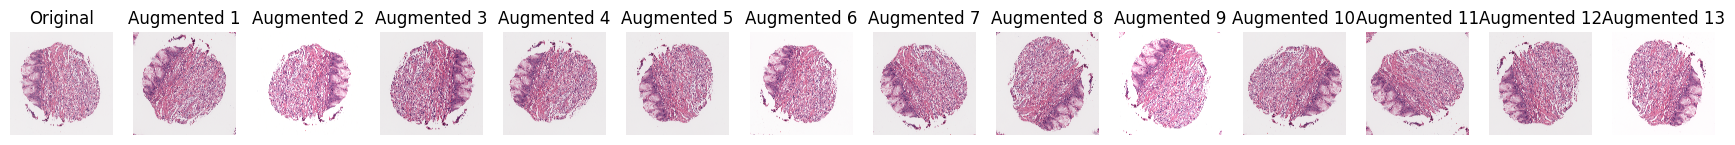

In [3]:
original_image_id = '21020'

# Get the paths of the original and augmented images
original_image_path = combined_tma[combined_tma['image_id'] == original_image_id]['path'].values[0]
augmented_image_paths = combined_tma[combined_tma['image_id'].str.startswith(original_image_id + '_')]['path'].values

# Load and display the images
fig, axes = plt.subplots(1, 14, figsize=(22, 8))
axes[0].imshow(Image.open(original_image_path))
axes[0].set_title('Original')
axes[0].axis('off')

for i, path in enumerate(augmented_image_paths):
    axes[i + 1].imshow(Image.open(path))
    axes[i + 1].set_title(f'Augmented {i+1}')
    axes[i + 1].axis('off')

plt.show()

In [4]:
# Convert 'image_id' column to string type
combined_tma['image_id'] = combined_tma['image_id'].astype(str)

# Separate original images from augmented ones
original_images = combined_tma[~combined_tma['image_id'].str.contains('_')]
augmented_images = combined_tma[combined_tma['image_id'].str.contains('_')]

# Ensure balanced selection of original images for the test set
# Here, we ensure we select at least one image from each class
test_orig = original_images.groupby('label').sample(n=1, random_state=42)

# Add augmented versions of these selected originals to the test set
test_aug = augmented_images[augmented_images['image_id'].str.split('_').str[0].isin(test_orig['image_id'])]
test_set = pd.concat([test_orig, test_aug])

# The training set consists of all images not in the test set
train_set = combined_tma[~combined_tma['image_id'].isin(test_set['image_id'])]

In [5]:
# Create a label to index mapping
label_to_idx = {label: idx for idx, label in enumerate(train_set['label'].unique())}

# Apply this mapping to your train and test sets
train_set['label_idx'] = train_set['label'].map(label_to_idx)
test_set['label_idx'] = test_set['label'].map(label_to_idx)

/tmp/ipykernel_179184/2633910165.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['label_idx'] = train_set['label'].map(label_to_idx)


In [6]:
# Print the label to index mapping
print(label_to_idx)

{'HGSC': 0, 'MC': 1, 'LGSC': 2, 'EC': 3, 'CC': 4}


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class TissueDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        image = Image.open(img_path)
        label = self.dataframe.iloc[idx]['label_idx']

        if self.transform:
            image = self.transform(image)

        return image, label


# Define transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets
train_dataset = TissueDataset(train_set, transform=transform)
test_dataset = TissueDataset(test_set, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [8]:
import timm
import torch.nn as nn

# Load a pre-trained model
model = timm.create_model('resnet50', pretrained=True)

# Modify the classifier
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

In [9]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 4

# Training loop
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/4, Loss: 1.1450753211975098
Epoch 2/4, Loss: 0.41639092564582825
Epoch 3/4, Loss: 0.020074984058737755
Epoch 4/4, Loss: 0.0026103127747774124


In [10]:
from sklearn.metrics import classification_report

model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        actuals.extend(labels.cpu().numpy())

# Reverse mapping from index to original label
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Convert indices back to original labels
predicted_labels = [idx_to_label[idx] for idx in predictions]
actual_labels = [idx_to_label[idx] for idx in actuals]

print(classification_report(actual_labels, predicted_labels, zero_division=0))

              precision    recall  f1-score   support

          CC       0.82      1.00      0.90        14
          EC       0.93      1.00      0.97        14
        HGSC       1.00      1.00      1.00        14
        LGSC       1.00      0.07      0.13        14
          MC       0.57      0.93      0.70        14

    accuracy                           0.80        70
   macro avg       0.86      0.80      0.74        70
weighted avg       0.86      0.80      0.74        70



In [11]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'models/resnet50_state_dict.pth')

In [12]:
# Display first few predictions and actuals
for i in range(70):  # Adjust the range as needed
    print(f"Actual: {actual_labels[i]}, Predicted: {predicted_labels[i]}")

Actual: CC, Predicted: CC
Actual: EC, Predicted: EC
Actual: HGSC, Predicted: HGSC
Actual: LGSC, Predicted: MC
Actual: MC, Predicted: MC
Actual: MC, Predicted: MC
Actual: MC, Predicted: MC
Actual: MC, Predicted: MC
Actual: MC, Predicted: MC
Actual: MC, Predicted: MC
Actual: MC, Predicted: MC
Actual: MC, Predicted: EC
Actual: MC, Predicted: MC
Actual: MC, Predicted: MC
Actual: MC, Predicted: MC
Actual: MC, Predicted: MC
Actual: MC, Predicted: MC
Actual: MC, Predicted: MC
Actual: HGSC, Predicted: HGSC
Actual: HGSC, Predicted: HGSC
Actual: HGSC, Predicted: HGSC
Actual: HGSC, Predicted: HGSC
Actual: HGSC, Predicted: HGSC
Actual: HGSC, Predicted: HGSC
Actual: HGSC, Predicted: HGSC
Actual: HGSC, Predicted: HGSC
Actual: HGSC, Predicted: HGSC
Actual: HGSC, Predicted: HGSC
Actual: HGSC, Predicted: HGSC
Actual: HGSC, Predicted: HGSC
Actual: HGSC, Predicted: HGSC
Actual: LGSC, Predicted: MC
Actual: LGSC, Predicted: CC
Actual: LGSC, Predicted: MC
Actual: LGSC, Predicted: MC
Actual: LGSC, Predicted:

In [13]:
# Save the model and optimizer state
save_path = './models/tma_72_model.pth'
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs
}
torch.save(checkpoint, save_path)

print(f'Model saved at {save_path}')

Model saved at ./models/tma_72_model.pth
